Try indep sites on two different paths of the tree

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

import adabmDCA
from adabmDCA.utils import get_device, get_dtype, get_mask_save
from adabmDCA.sampling import get_sampler
from adabmDCA.functional import one_hot

import sys
sys.path.append('..')
import indep_sites, utils

/Users/scrotti/Aptamer2025py/experiments/../indep_sites.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
import importlib
importlib.reload(indep_sites)

<module 'indep_sites' from '/Users/scrotti/Aptamer2025py/experiments/../indep_sites.py'>

File names for data

In [5]:
experiment_id = "Dop8V030"
round_ids = ["ARN", "R01", "R02N", "R02F", "R02S", "R02SF"]

In [6]:
device = get_device("")
dtype = get_dtype("float32")

Running on CPU


Extract sequences and compute 1st and 2nd moment statistics

In [7]:
sequences = [utils.sequences_from_file(experiment_id, round_id, device) for round_id in round_ids]

In [8]:
ts = range(len(sequences))

In [9]:
alpha = 0.0
pseudo_count = alpha

In [10]:
freq_single_tuple, freq_pair_tuple, total_reads_tuple = zip(
    *[utils.frequences_from_sequences(seq, pseudo_count=pseudo_count, dtype=dtype) for seq in sequences])

In [11]:
fi = torch.stack(freq_single_tuple)  # n_rounds, L, q
fij = torch.stack(freq_pair_tuple)      # n_rounds, L, q, L, q
total_reads = torch.tensor(total_reads_tuple, dtype=dtype)

n_rounds, L, q = fi.size()

In [23]:
paths = [np.array([0, 1, 2]), np.array([0, 1, 3]), np.array([0, 1, 4]), np.array([0, 1, 5])]
n_paths = len(paths)
path_labels = ['norm A, norm W', 'fast A, norm W', 'norm A, high W', 'fast A, high W']

In [13]:
fi_paths = [fi[p] for p in paths]
total_reads_paths = [total_reads[p] for p in paths]

In [14]:
params_paths = []
histories_paths = []

for p in range(len(paths)):
    fi_path = fi_paths[p]
    total_reads_path = total_reads_paths[p]
    
    history = indep_sites.init_history()
    params=indep_sites.init_parameters(fi_path)
    
    params, history = indep_sites.train(
        fi = fi_path,
        total_reads = total_reads_path,
        params = params,
        lr = 1e-2,    
        max_epochs = 5*10**4,
        target_error = 1e-12,
        history = history,
        progress_bar = False
    )

    params_paths.append(params)
    histories_paths.append(history)

    print('Finished')

Finished
Finished
Finished
Finished


In [15]:
params_paths_zerosum = [indep_sites.set_zerosum_gauge(p) for p in params_paths]

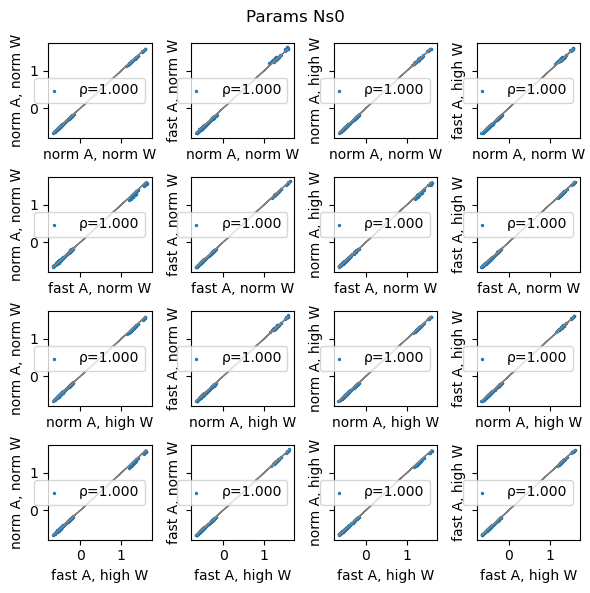

In [34]:
fig, axes = plt.subplots(n_paths, n_paths, sharex=True, sharey=True, figsize=(6,6))

for i in range(n_paths):
    for j in range(n_paths):
        ax = axes[i,j]
        x = params_paths_zerosum[i]["bias_Ns0"].view(-1)
        y = params_paths_zerosum[j]["bias_Ns0"].view(-1)
        rho = torch.corrcoef(torch.stack((x,y)))[0,1].item()
        ax.scatter(x, y, s=2, label=f'ρ={rho:.3f}')
        ax.legend()
        ax.plot(x, x, color='gray', lw=1)
        ax.set_xlabel(path_labels[i])
        ax.set_ylabel(path_labels[j])
fig.suptitle('Params Ns0')
fig.tight_layout()

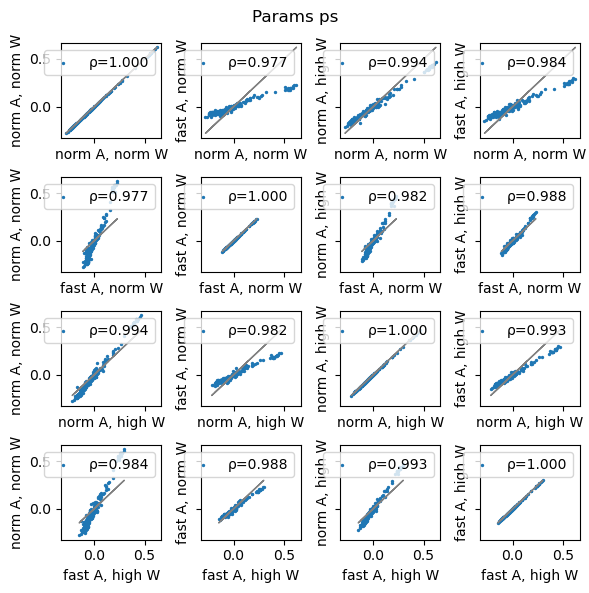

In [35]:
fig, axes = plt.subplots(n_paths, n_paths, sharex=True, sharey=True, figsize=(6,6))

for i in range(n_paths):
    for j in range(n_paths):
        ax = axes[i,j]
        x = params_paths_zerosum[i]["bias_ps"].view(-1)
        y = params_paths_zerosum[j]["bias_ps"].view(-1)
        rho = torch.corrcoef(torch.stack((x,y)))[0,1].item()
        ax.scatter(x, y, s=2, label=f'ρ={rho:.3f}')
        ax.legend()
        ax.plot(x, x, color='gray', lw=1)
        ax.set_xlabel(path_labels[i])
        ax.set_ylabel(path_labels[j])
fig.suptitle('Params ps')
fig.tight_layout()

In [119]:
idx_wt_full, wt_full = selex_dca.guess_wildtype_from_sequence_counts(sequences_unique[0], counts[0])
wt_site = selex_dca.guess_wildtype_from_site_counts(fi_round_zero)

In [115]:
selex_dca.hamming(wt_full, wt_site)

0

In [1]:
selex_dca.hamming(params["bias_Ns0"].argmax(dim=1), wt_site)

NameError: name 'selex_dca' is not defined

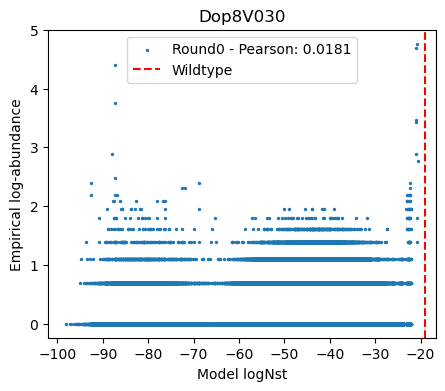

In [117]:
N = 5*10**5

fig, ax = plt.subplots(figsize=(5,4))

t = 0
x = X[t]; y = Y[t]
pearson = torch.corrcoef(torch.stack((x, y)))[0,1]
idx = random.sample(range(len(x)),min(N, len(x)))
ax.scatter(x[idx], y[idx], label=f"Round{t} - Pearson: {pearson:.{4}f}", s=2)
ax.set_xlabel("Model logNst")
ax.set_ylabel("Empirical log-abundance")
ax.set_title(f"{experiment_id}")
ax.axvline(logNst_wt, label="Wildtype", c="r", ls="--")
ax.legend();